In [11]:
import sys
sys.path.append('../src')
from data import get_cleaned_dataframes
from models import classification, get_word2vec_model
from gensim.models import Word2Vec

load the preprocessed texts in all languages into a dataframe

In [12]:
cleaned_dataframe = get_cleaned_dataframes()

Split data into train and test sets

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(cleaned_dataframe['cleaned_texts'], cleaned_dataframe['label'] , test_size=0.3)

## Word2Vec
### Parameters:
- vector_size - vector size
- window - num of words before and after the focus word considered as context for the word
- min_count - the number of times a word must appear in our corpus in order to create a word vector.

Train a Word2Vec model with the train set

In [4]:
model, word_vectors = get_word2vec_model(X_train, text_type="cleaned_texts")

Word2Vec model not found.
Training new model on 130 documents.
Saving new model.
Model:  /home/Bachelor-Thesis/models/classification/Word2Vec_en_cleaned_texts  loaded


## Text Classification on manually trained Word2Vec model

### Create features from text for machine learning model.
Steps:
- Turn words in texts into word vectors.
- Method 1: averaging word vectors for each text

In [5]:
X_train_vect = classification.text2vec(X_train, word_vectors)
X_test_vect = classification.text2vec(X_test, word_vectors)

In [6]:
X_train_vect_avg = classification.average_vector(X_train_vect)
X_test_vect_avg = classification.average_vector(X_test_vect)

### Classification reports:
- Recall = how many of this class where found over whole num of elements of this class
- Precision = how many correctly classified among that class
- f1-score: harmonic mean between precision and recall
- support: num of occurrence of given class in dataset

Instantiate and fit a basic Random Forest model on top of the vectors

In [7]:
y_pred = classification.classify_predict(X_train_vect_avg, X_test_vect_avg, y_train, "Random Forest")
classification.print_classification_report(y_test, y_pred)

y_pred = classification.classify_predict(X_train_vect_avg, X_test_vect_avg, y_train, "Multinomial Naive Bayes")
classification.print_classification_report(y_test, y_pred)

y_pred = classification.classify_predict(X_train_vect_avg, X_test_vect_avg, y_train, "SVM")
classification.print_classification_report(y_test, y_pred)

############################################################################
Processing Random Forest Classification

              precision    recall  f1-score   support

    verfolgt       1.00      0.84      0.91        57
    begnadet       0.00      0.00      0.00         0

    accuracy                           0.84        57
   macro avg       0.50      0.42      0.46        57
weighted avg       1.00      0.84      0.91        57

classes in y_pred: {0, 1} classes in y_test: {0}
############################################################################
############################################################################
Processing Multinomial Naive Bayes Classification

              precision    recall  f1-score   support

    verfolgt       1.00      0.84      0.91        57
    begnadet       0.00      0.00      0.00         0

    accuracy                           0.84        57
   macro avg       0.50      0.42      0.46        57
weighted avg       1.00      

<AxesSubplot: ylabel='label'>

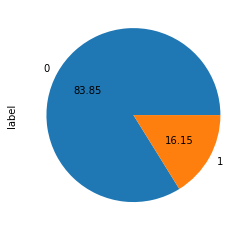

In [8]:
y_train.value_counts().plot.pie(autopct='%0.2f')

Highly Imbalanced Dataset!
Ideas:
- Undersampling: reduce majority class to make it equal to minority class
- Oversampling: increase minority class to make it equal to majority class through resampling
- K-fold cross validation

## Oversampling

In [9]:
!pip install imblearn
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy="not majority")
X_train_2d = X_train.values.reshape(-1, 1) # puts each elem of array in own array
X_res, y_res = ros.fit_resample(X_train_2d, y_train)

0    109
1    109
Name: label, dtype: int64


<AxesSubplot: ylabel='label'>

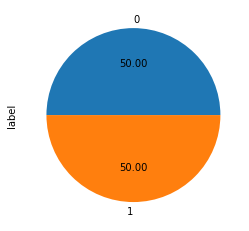

In [10]:
print(y_res.value_counts())
y_res.value_counts().plot.pie(autopct='%0.2f')

In [11]:
#X_res revert 2_dimensionality
X_res_1d = X_res.flatten()

# classification with resampled vectors
X_res_vect = classification.text2vec(X_res_1d, word_vectors)
X_res_vect_avg = classification.average_vector(X_res_vect)

In [12]:
y_res_pred = classification.classify_predict(X_res_vect_avg, X_test_vect_avg, y_res, "Random Forest")
classification.print_classification_report(y_test, y_res_pred)
y_res_pred = classification.classify_predict(X_res_vect_avg, X_test_vect_avg, y_res, "Multinomial Naive Bayes")
classification.print_classification_report(y_test, y_res_pred)
y_res_pred = classification.classify_predict(X_res_vect_avg, X_test_vect_avg, y_res, "SVM")
classification.print_classification_report(y_test, y_res_pred)

############################################################################
Processing Random Forest Classification

              precision    recall  f1-score   support

    verfolgt       0.92      0.83      0.87        53
    begnadet       0.00      0.00      0.00         4

    accuracy                           0.77        57
   macro avg       0.46      0.42      0.44        57
weighted avg       0.85      0.77      0.81        57

classes in y_pred: {0, 1} classes in y_test: {0, 1}
############################################################################
############################################################################
Processing Multinomial Naive Bayes Classification

              precision    recall  f1-score   support

    verfolgt       0.67      0.82      0.74        39
    begnadet       0.22      0.11      0.15        18

    accuracy                           0.60        57
   macro avg       0.44      0.47      0.44        57
weighted avg       0.53   

## Undersampling

In [13]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0, sampling_strategy="majority")
X_resampled, y_resampled = rus.fit_resample(X_train_2d, y_train)

0    21
1    21
Name: label, dtype: int64


<AxesSubplot: ylabel='label'>

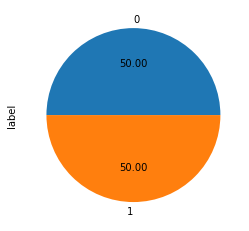

In [14]:
print(y_resampled.value_counts())
y_res.value_counts().plot.pie(autopct='%0.2f')

In [15]:
#X_res revert 2_dimensionality
X_resampled_1d = X_resampled.flatten()

# classification with resampled vectors
X_resampled_vect = classification.text2vec(X_resampled_1d, word_vectors)
X_resampled_vect_avg = classification.average_vector(X_resampled_vect)

In [16]:
y_resampled_pred = classification.classify_predict(X_resampled_vect_avg, X_test_vect_avg, y_resampled, "Random Forest")
classification.print_classification_report(y_test, y_resampled_pred)
y_resampled_pred = classification.classify_predict(X_resampled_vect_avg, X_test_vect_avg, y_resampled, "Multinomial Naive Bayes")
classification.print_classification_report(y_test, y_resampled_pred)
y_resampled_pred = classification.classify_predict(X_resampled_vect_avg, X_test_vect_avg, y_resampled, "SVM")
classification.print_classification_report(y_test, y_resampled_pred)

############################################################################
Processing Random Forest Classification

              precision    recall  f1-score   support

    verfolgt       0.40      0.83      0.54        23
    begnadet       0.56      0.15      0.23        34

    accuracy                           0.42        57
   macro avg       0.48      0.49      0.38        57
weighted avg       0.49      0.42      0.35        57

classes in y_pred: {0, 1} classes in y_test: {0, 1}
############################################################################
############################################################################
Processing Multinomial Naive Bayes Classification

              precision    recall  f1-score   support

    verfolgt       0.25      0.86      0.39        14
    begnadet       0.78      0.16      0.27        43

    accuracy                           0.33        57
   macro avg       0.51      0.51      0.33        57
weighted avg       0.65   